<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [57]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib

Overwriting requirements.txt


In [58]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from skimage import io
from torchvision import transforms as torch_transforms
import pylab as plt

## Specify global parameters

In [9]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

In [10]:
np.random.seed(random_seed)

## Download data from MLHUB


In [11]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [12]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

MLHub API Key: ··········


  0%|          | 0/0.5 [00:00<?, ?M/s]

  0%|          | 0/324.3 [00:00<?, ?M/s]

  0%|          | 0/1.3 [00:00<?, ?M/s]

## Prepare Training data


### Create training dataframe

In [13]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [14]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,91b2b,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,63409,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,964ef,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,98d1c,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,66e24,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...


### Split the data into train and validation

In [15]:
ind = np.arange(len(train_data))
np.random.shuffle(ind)

In [16]:
val_fraction = 0.2
n_val = int(round(val_fraction * len(train_data)))
n_val

233

In [17]:
train_data['split'] = ''
train_data['split'][ind[:n_val]] = 'validation'
train_data['split'][ind[n_val:]] = 'train'
train_data.head()

,folder_id,field_path,label_path,source_path,split
0,91b2b,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
1,63409,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
2,964ef,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
3,98d1c,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
4,66e24,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train


In [18]:
train_data.to_csv(train_df_path, index=False)

## Specify Data Loading pipeline

### Specify parameters

In [19]:
batch_size = 16

### Specify the Dataset

In [53]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, phase='train', transforms=None, 
               band_names=BAND_NAMES):
    assert phase in ['train', 'validation']
    self.df = df[df['split'] == phase]
    self.transforms = transforms if transforms is not None\
      else torch_transforms.ToTensor()
    self.band_names = band_names

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64))
    with rasterio.open(self.df.iloc[index]['label_path']) as src:
      labels = src.read()[0].astype(np.int64)
      
    seed = np.random.randint(np.iinfo('int32').max)
    torch.manual_seed(seed)
    labels = self.transforms(labels)
    new_imgs = []
    for img in imgs:
      torch.manual_seed(seed)
      new_imgs.append(self.transforms(img))

    return torch.stack(new_imgs).squeeze(1), labels

  def __len__(self):
    return len(self.df)

In [79]:
dl_train = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train'), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='validation'), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [80]:
imgs, labels = next(iter(dl_train))

In [81]:
imgs.shape, labels.shape

(torch.Size([16, 12, 256, 256]), torch.Size([16, 1, 256, 256]))

In [88]:
ind = 0
s = 3

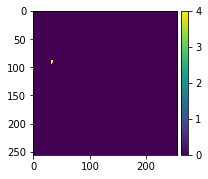

In [89]:
plt.figure(figsize=(s,s))
io.imshow(labels[ind][0].numpy())

In [90]:
sl = tuple([slice(70, 100), slice(20, 50)])

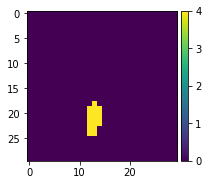

In [91]:
plt.figure(figsize=(s,s))
io.imshow(labels[ind][0][sl].numpy())

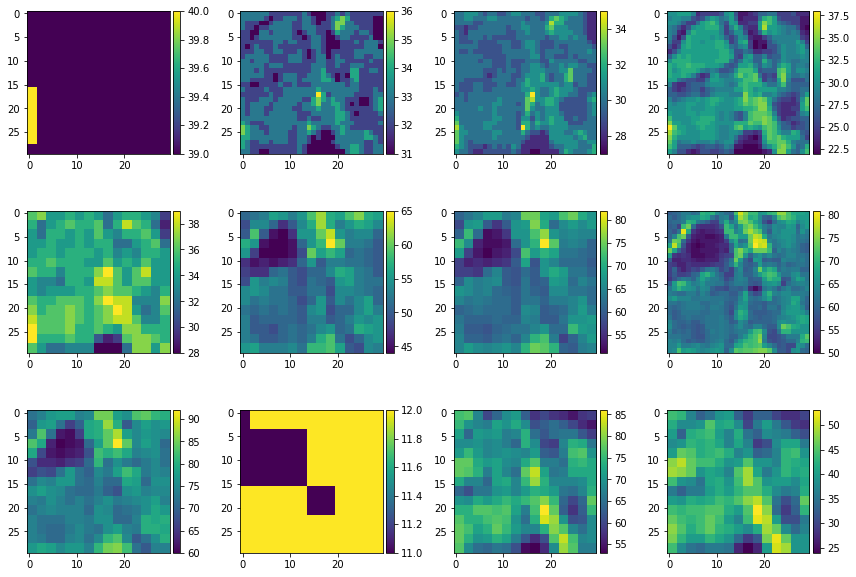

In [92]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs[ind]):
  plt.sca(ax)
  io.imshow(img[sl].numpy())